In [40]:
import sklearn
print(sklearn.__version__)

1.3.2


In [43]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report

In [2]:
price_data = pd.read_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa.xlsx', sheet_name= "Sheet1")
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.297814,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.282718,227,ABEV3.SA
2,2000-01-07,0.494478,0.494478,0.494478,0.494478,0.282718,151,ABEV3.SA
3,2000-01-10,0.494478,0.494478,0.494478,0.494478,0.282718,1516,ABEV3.SA
4,2000-01-11,0.494478,0.494478,0.494478,0.494478,0.282718,3791,ABEV3.SA


In [5]:
price_data = price_data.rename(columns={'Ticker':'symbol', 'Date':'datetime','Close':'close','High':'high','Low':'low','Open':'open', 'Volume':'volume'})

price_data = price_data[['symbol','datetime','close','high','low','open','volume']]

# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['close'].diff()
price_data.head(10)

,symbol,datetime,close,high,low,open,volume,change_in_price
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000


In [6]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18643 entries, 0 to 18642
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           18643 non-null  object        
 1   datetime         18643 non-null  datetime64[ns]
 2   close            18643 non-null  float64       
 3   high             18643 non-null  float64       
 4   low              18643 non-null  float64       
 5   open             18643 non-null  float64       
 6   volume           18643 non-null  int64         
 7   change_in_price  18642 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price
18638,VALE3.SA,2024-09-23,57.529999,57.860001,56.599998,57.090000,18164700,0.180000
18639,VALE3.SA,2024-09-24,60.340000,60.740002,59.639999,60.209999,44910100,2.810001
18640,VALE3.SA,2024-09-25,60.610001,61.250000,60.419998,60.720001,21557700,0.270000
18641,VALE3.SA,2024-09-26,64.250000,64.379997,62.450001,62.599998,61449300,3.639999
18642,VALE3.SA,2024-09-27,63.959999,65.040001,63.169998,64.699997,37237900,-0.290001


In [7]:
price_data1 = price_data.copy()

#### Tirando a diferença do 'close' na virada de um tick para outro.

In [16]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]

,symbol,datetime,close,high,low,open,volume,change_in_price
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN
6213,SBSP3.SA,2000-01-03,7.815000,7.962916,7.777916,7.888750,2536,NaN
12428,VALE3.SA,2000-01-03,3.500000,3.542500,3.500000,3.500000,585600,NaN


In [24]:
price_data[mask]

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0
6213,SBSP3.SA,2000-01-03,7.815000,7.962916,7.777916,7.888750,2536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.061137,NaN,0
12428,VALE3.SA,2000-01-03,3.500000,3.542500,3.500000,3.500000,585600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.097776,NaN,0


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [17]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [18]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652,NaN,NaN,NaN


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [20]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * (- 100)

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN,NaN
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN,NaN
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN,NaN
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652,NaN,NaN,NaN,NaN


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [21]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000592,-0.000329
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000755,-0.000504
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000810,-0.000607
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000823,-0.000672
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001379,-0.000863
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN,NaN,-0.001563,-0.001041
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN,NaN,-0.001191,-0.001077
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN,NaN,0.000722,-0.000661
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652,NaN,NaN,NaN,NaN,0.002069,-0.000049


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [22]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000592,-0.000329,NaN
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000755,-0.000504,NaN
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000810,-0.000607,NaN
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000823,-0.000672,NaN
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001379,-0.000863,NaN
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN,NaN,-0.001563,-0.001041,NaN
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN,NaN,-0.001191,-0.001077,NaN
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN,NaN,0.000722,-0.000661,NaN
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652,NaN,NaN,NaN,NaN,0.002069,-0.000049,0.012655


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [23]:
def obv(group):

    # Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,ABEV3.SA,2000-01-05,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1,ABEV3.SA,2000-01-06,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000592,-0.000329,NaN,-227
2,ABEV3.SA,2000-01-07,0.494478,0.494478,0.494478,0.494478,151,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000755,-0.000504,NaN,-227
3,ABEV3.SA,2000-01-10,0.494478,0.494478,0.494478,0.494478,1516,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000810,-0.000607,NaN,-227
4,ABEV3.SA,2000-01-11,0.494478,0.494478,0.494478,0.494478,3791,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000823,-0.000672,NaN,-227
5,ABEV3.SA,2000-01-12,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001379,-0.000863,NaN,-1364
6,ABEV3.SA,2000-01-13,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN,NaN,-0.001563,-0.001041,NaN,-758
7,ABEV3.SA,2000-01-14,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN,NaN,-0.001191,-0.001077,NaN,5687
8,ABEV3.SA,2000-01-17,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN,NaN,0.000722,-0.000661,NaN,31243
9,ABEV3.SA,2000-01-18,0.527474,0.527474,0.527474,0.527474,0,0.000000,0.000000,0.000000,70.668652,NaN,NaN,NaN,NaN,0.002069,-0.000049,0.012655,31243


## Modelando.

In [ ]:
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

In [25]:
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0




price_data.to_csv('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/price_data.csv')

In [26]:
# print the head
price_data.head(20)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,ABEV3.SA,2000-01-05 00:00:00,0.520882,0.520882,0.520882,0.520882,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
1,ABEV3.SA,2000-01-06 00:00:00,0.494478,0.494478,0.494478,0.494478,227,-0.026404,0.026404,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000592,-0.000329,NaN,-227,-1.0
2,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.0
3,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.0
4,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.0
5,ABEV3.SA,2000-01-12 00:00:00,0.481293,0.481293,0.481293,0.481293,1137,-0.013185,0.013185,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001379,-0.000863,NaN,-1364,-1.0
6,ABEV3.SA,2000-01-13 00:00:00,0.484589,0.484589,0.484589,0.484589,606,0.003296,0.000000,0.003296,11.927770,NaN,NaN,NaN,NaN,-0.001563,-0.001041,NaN,-758,1.0
7,ABEV3.SA,2000-01-14 00:00:00,0.494478,0.494478,0.494478,0.494478,6445,0.009889,0.000000,0.009889,37.666643,NaN,NaN,NaN,NaN,-0.001191,-0.001077,NaN,5687,1.0
8,ABEV3.SA,2000-01-17 00:00:00,0.527474,0.527474,0.527474,0.527474,25556,0.032996,0.000000,0.032996,70.668652,NaN,NaN,NaN,NaN,0.000722,-0.000661,NaN,31243,1.0
9,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.0


In [27]:
price_data['Prediction'].unique()

array([nan, -1.,  1.])

## Removendo Nans

In [28]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 18643 rows and 20 columns
After NaN Drop we have 18613 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
2,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
10,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0


## Split dos dados

In [35]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [36]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  72.86205414697035


In [37]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.703261,0.712756,0.707977,2148.000000
Up Day,0.750908,0.742219,0.746538,2506.000000
accuracy,0.728621,0.728621,0.728621,0.728621
macro avg,0.727085,0.727487,0.727258,4654.000000
weighted avg,0.728917,0.728621,0.728741,4654.000000


Accuracy: 0.7286205414697035
Precision: 0.7509083568833266
Recall: 0.7422186751795691
Specificity: 0.712756052141527


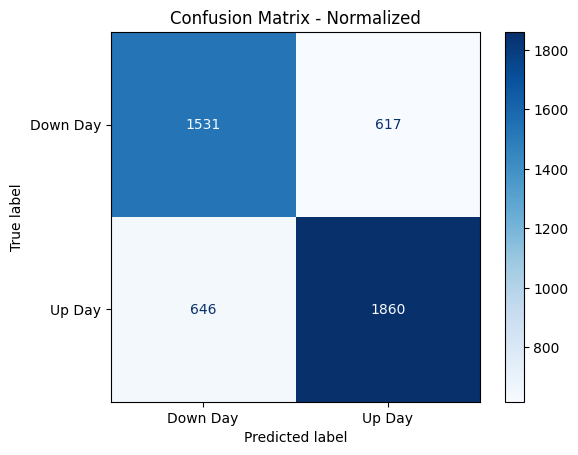

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


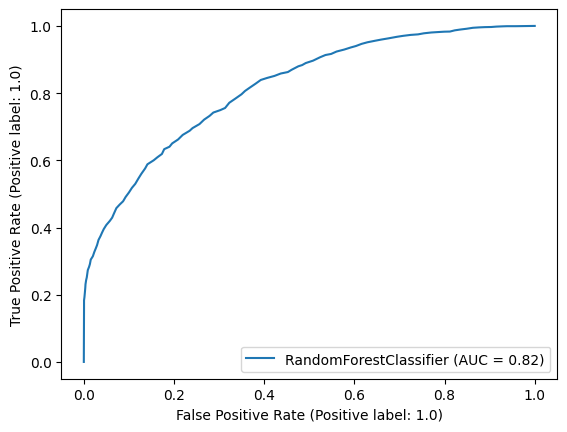

In [47]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test)
plt.show()
